In [2]:
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray
import xarray as xr
from affine import Affine
from geopandas.geodataframe import GeoDataFrame
from rasterio.features import rasterize
from sklearn.ensemble import RandomForestClassifier

from training_raster_clipper.core.logging import log_info
from training_raster_clipper.core.models import TrainingConfiguration, TrainingFunctions
from training_raster_clipper.core.visualization import (
    plot_array,
    plot_geodataframe,
    plot_rgb_data_array,
)
from training_raster_clipper.custom_types import (
    BandNameType,
    ClassificationResult,
    ClassifiedSamples,
    FeatureClassNameToId,
    PolygonMask,
    ResolutionType,
)

config = TrainingConfiguration(
    verbose=True,
    show_plots=True,
    resolution=60,
    band_names=("B04", "B03", "B02", "B8A"),
    raster_input_path=Path(
        "D:/PROFILS/ESCHALK/DOWNLOADS/S2A_MSIL2A_20221116T105321_N0400_R051_T31TCJ_20221116T170958/S2A_MSIL2A_20221116T105321_N0400_R051_T31TCJ_20221116T170958.SAFE"
    ),
    polygons_input_path=(
        Path(".").resolve().parent / Path("resources/solution/polygons.geojson")
    ),
    csv_output_path=(
        Path(".").resolve().parent / Path("generated/classified_points.csv")
    ),
    raster_output_path=(
        Path(".").resolve().parent / Path("generated/sklearn_raster.tiff")
    ),
    implementation_name="eschalk",
)
config

TrainingConfiguration(verbose=True, show_plots=True, resolution=60, band_names=('B04', 'B03', 'B02', 'B8A'), raster_input_path=WindowsPath('D:/PROFILS/ESCHALK/DOWNLOADS/S2A_MSIL2A_20221116T105321_N0400_R051_T31TCJ_20221116T170958/S2A_MSIL2A_20221116T105321_N0400_R051_T31TCJ_20221116T170958.SAFE'), polygons_input_path=WindowsPath('D:/Profils/eschalk/dev/playground/python/training/training-raster-clipper/resources/solution/polygons.geojson'), csv_output_path=WindowsPath('D:/Profils/eschalk/dev/playground/python/training/training-raster-clipper/generated/classified_points.csv'), raster_output_path=WindowsPath('D:/Profils/eschalk/dev/playground/python/training/training-raster-clipper/generated/sklearn_raster.tiff'), implementation_name='eschalk')

In [3]:
from training_raster_clipper.implementation.eschalk import (
    load_feature_polygons,
    load_sentinel_data,
    rasterize_geojson,
    produce_clips,
    persist_to_csv,
    classify_sentinel_data,
    persist_classification_to_raster,
)

interface = TrainingFunctions(
    load_feature_polygons=load_feature_polygons,
    load_sentinel_data=load_sentinel_data,
    rasterize_geojson=rasterize_geojson,
    produce_clips=produce_clips,
    persist_to_csv=persist_to_csv,
    classify_sentinel_data=classify_sentinel_data,
    persist_classification_to_raster=persist_classification_to_raster,
)
interface

TrainingFunctions(load_feature_polygons=<function load_feature_polygons at 0x000001714E74FC70>, load_sentinel_data=<function load_sentinel_data at 0x000001714E74FA30>, rasterize_geojson=<function rasterize_geojson at 0x000001714E9477F0>, produce_clips=<function produce_clips at 0x0000017101FFF520>, persist_to_csv=<function persist_to_csv at 0x0000017101FFF1C0>, classify_sentinel_data=<function classify_sentinel_data at 0x0000017101FFF2E0>, persist_classification_to_raster=<function persist_classification_to_raster at 0x0000017101FFF5B0>)

In [4]:
verbose = config.verbose
show_plots = config.show_plots

resolution = config.resolution
band_names = config.band_names

raster_input_path = config.raster_input_path
polygons_input_path = config.polygons_input_path
csv_output_path = config.csv_output_path
raster_output_path = config.raster_output_path

### (1) Load a GeoJSON file with `geopandas`

In [5]:
def load_feature_polygons(input_path: Path) -> GeoDataFrame:
    return interface.load_feature_polygons(input_path)

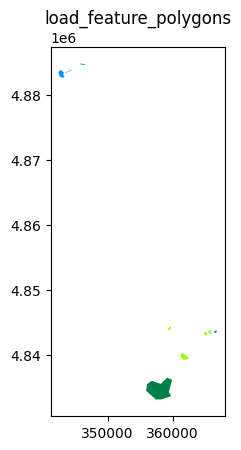

In [6]:
polygons = load_feature_polygons(polygons_input_path)
if verbose:
    log_info(polygons, "polygons")
if show_plots:
    plot_geodataframe(polygons, f"{load_feature_polygons.__name__}")


### (2) Load a Sentinel-2 raster with `rioxarray`

In [7]:
def load_sentinel_data(
    sentinel_product_location: Path,
    resolution: ResolutionType,
    band_names: tuple[BandNameType, ...],
) -> xr.DataArray:
    """Loads sentinel product

    Example input path: `S2A_MSIL2A_20221116T105321_N0400_R051_T31TCJ_20221116T170958.SAFE`

    Args:
        sentinel_product_location (Path): Location of the .SAFE folder containing a Sentinel-2 product.

    Returns:
        xr.DataArray: A DataArray containing the 3 RGB bands from the visible spectrum
    """

    return interface.load_sentinel_data(raster_input_path, resolution, band_names)


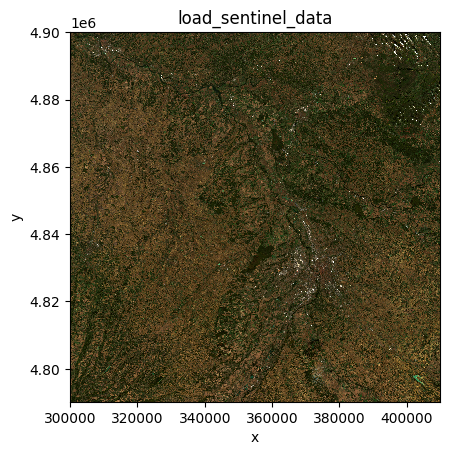

In [8]:


rasters = load_sentinel_data(raster_input_path, resolution, band_names)
if verbose:
    log_info(rasters, "rasters")
if show_plots:
    plot_rgb_data_array(rasters, f"{load_sentinel_data.__name__}")



### (3) Rasterize the polygons

In [9]:
def rasterize_geojson(
    data_array: xr.DataArray,
    training_classes: GeoDataFrame,
) -> tuple[PolygonMask, FeatureClassNameToId]:
    """Burns a set of vectorial polygons to a raster.

    See https://gis.stackexchange.com/questions/316626/rasterio-features-rasterize

    Args:
        data_array (xr.DataArray): The Sentinel raster, from which data is taken, such as the transform or the shape.
        training_classes (GeoDataFrame): The input set of classified multipolygons to burn

    Returns:
        xr.DataArray: A mask raster generated from the polygons, representing the same geographical region as the source dataarray param
                      0 where no polygon were found, and integers representing classes in order of occurence in the GeoDataFrame
    """

    return interface.rasterize_geojson(rasters, polygons)


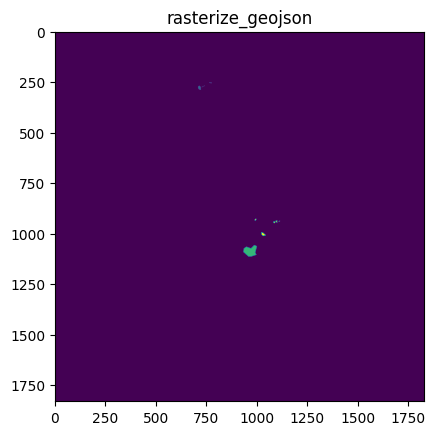

In [10]:

burnt_polygons, mapping = rasterize_geojson(rasters, polygons)
if verbose:
    log_info(burnt_polygons, "burnt_polygons")
    log_info(mapping, "mapping")
if show_plots:
    plot_array(burnt_polygons, f"{rasterize_geojson.__name__}")



### (4) Intersect the Sentinel-2 raster with polygons

In [11]:
def produce_clips(
    data_array: xr.DataArray, burnt_polygons: PolygonMask, mapping: FeatureClassNameToId
) -> ClassifiedSamples:
    """Extract RGB values covered by classified polygons

    Args:
        data_array (xr.DataArray): RGB raster
        burnt_polygons (PolygonMask): Rasterized classified multipolygons

    Returns:
        _type_: A list of the RGB values contained in the data_array and their corresponding classes
    """

    return interface.produce_clips(rasters, burnt_polygons, mapping)



In [12]:
classified_rgb_rows = produce_clips(rasters, burnt_polygons, mapping)
if verbose:
    log_info(classified_rgb_rows, "classified_rgb_rows")



### (5) Persist the intersection to a CSV

In [13]:

def persist_to_csv(
    classified_rgb_rows: ClassifiedSamples,
    csv_output_path: Path,
) -> None:
    return interface.persist_to_csv(classified_rgb_rows, csv_output_path)

In [14]:
persist_to_csv(classified_rgb_rows, csv_output_path)
log_info(f"Written CSV output {csv_output_path}")

### (6) Train a machine learning model

In [15]:
def classify_sentinel_data(
    rasters: xr.DataArray, classified_rgb_rows: ClassifiedSamples
) -> ClassificationResult:
    return interface.classify_sentinel_data(
        rasters, classified_rgb_rows
    )


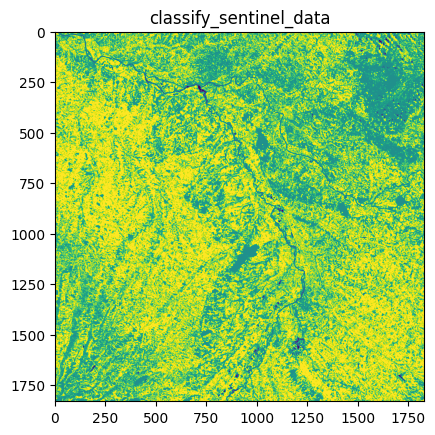

In [16]:
classification_result = classify_sentinel_data(
    rasters, classified_rgb_rows
)
if verbose:
    log_info(classification_result, "classification_result")
if show_plots:
    plot_array(
        classification_result, f"{classify_sentinel_data.__name__}"
    )


### (7) Export the classification raster result

In [17]:
def persist_classification_to_raster(
    raster_output_path: Path, classification_result: ClassificationResult
) -> None:
    return interface.persist_classification_to_raster(
        raster_output_path, classification_result
    )


In [18]:

persist_classification_to_raster(
    raster_output_path, classification_result
)
log_info(f"Written Classified Raster to {csv_output_path}")

# --

log_info("Congratulations, you reached the end of the tutorial!")
